In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from standardization_process import plot_reg_correlation,plot_diagram,unreliable_datapoints,plot_cls_correlation,identify_unreliable_group,final_mean_value
from data_split import train_test_split

In [3]:
def remove_bad_datapoints(df,controlled_list,value_col,fold=np.log10(3)):
    bad_datapoints_index = unreliable_datapoints(df, controlled_list, value_col)
    df = df.loc[~df.index.isin(bad_datapoints_index),] 
    
    bad_group_index = identify_unreliable_group(df, controlled_list, value_col, fold=fold)
    
    df = df.loc[~df.index.isin(bad_group_index),] 
    
    
    return df

In [4]:
def compound_property_analysis(mol_list):
    atom_counts = mol_list.map(lambda x: x.GetNumAtoms())
    qed = mol_list.parallel_apply(Descriptors.qed)
    logp = mol_list.parallel_apply(Descriptors.MolLogP)
    TPSA = mol_list.parallel_apply(Descriptors.TPSA)
    HBD = mol_list.parallel_apply(Descriptors.NumHDonors)
    HBA = mol_list.parallel_apply(Descriptors.NumHAcceptors)
    
    fig, axs = plt.subplots(3,2, figsize=(16, 10))

    # Plot data
    axs[0, 0].hist(qed, bins=20, color='b', alpha=0.7, label='A')
    axs[0, 0].set_title('qed')

    axs[0, 1].hist(atom_counts, bins=20, color='r', alpha=0.7, label='B')
    axs[0, 1].set_title('atom_counts')

    axs[1, 0].hist(logp, bins=20, color='g', alpha=0.7, label='C')
    axs[1, 0].set_title('logp')

    axs[1, 1].hist(TPSA, bins=20, color='y', alpha=0.7, label='D')
    axs[1, 1].set_title('TPSA')

    axs[2, 0].hist(HBD, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 0].set_title('HBD')

    axs[2, 1].hist(HBA, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 1].set_title('HBA')

    # Add some labels and titles for better readability
    for ax in axs.flat:
        ax.set( ylabel='Frequency')


    plt.show()

# Load data

In [5]:
df = pd.read_csv('../data/data_processing_result/solubility_preprocessing_finished.csv')

In [6]:
df.shape

(14818, 9)

In [7]:
df.head(3)

,Smiles_unify,Smiles,value_nM,value_nM_log,ref,source,Temperature,pH,property
0,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,1.341523e+07,7.1276,CHEMBL1138134,ChEMBL,other,7.4,solubility
1,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,6.339401e+04,4.8020,CHEMBL1151763,ChEMBL,other,7.4,solubility
2,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,6.477938e+03,3.8114,CHEMBL1944507,ChEMBL,other,7.0,solubility


<AxesSubplot:>

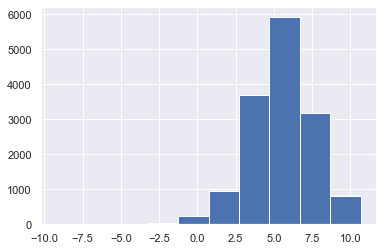

In [8]:
df['value_nM_log'].hist()

# Dataset correlation

In [9]:
df['source'].value_counts(dropna=False)

Cuietal         8450
Wangetal        2674
ChEMBL          2367
ESOL             664
ONSchallenge     663
Name: source, dtype: int64

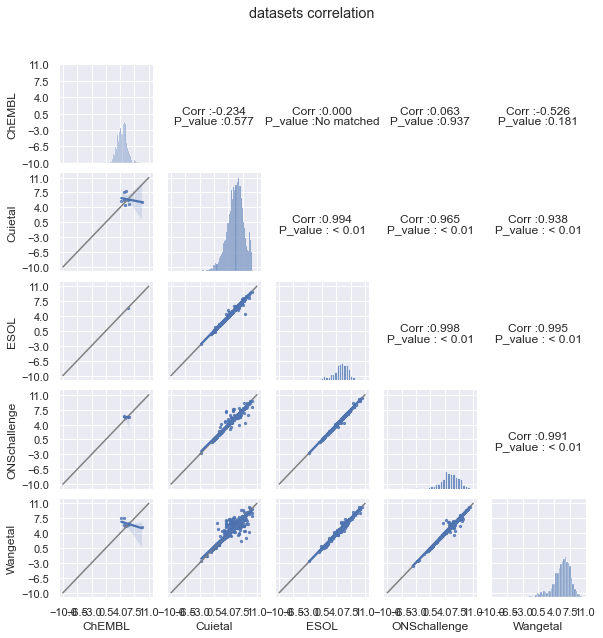

In [10]:
plot_reg_correlation(df, ['Smiles_unify'], 'source', 'value_nM_log', fig_title='datasets correlation')

## drop unreliable datasets

In [11]:
df[(df['source'] == 'Wangetal') & (df['ref'] == 'Goodman’s data set')].shape

(88, 9)

In [12]:
df = df[~((df['source'] == 'Wangetal') & (df['ref'] == 'Goodman’s data set'))]
df.shape

(14730, 9)

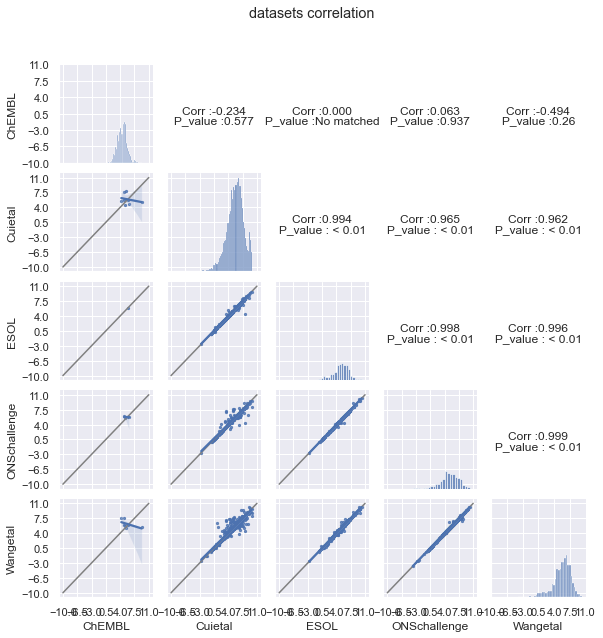

In [13]:
plot_reg_correlation(df, ['Smiles_unify'], 'source', 'value_nM_log', fig_title='datasets correlation')

# Repeated values

In [14]:
df.drop_duplicates(subset=['Smiles_unify', 'value_nM_log', 'Temperature'], inplace=True)
df.shape

(14171, 9)

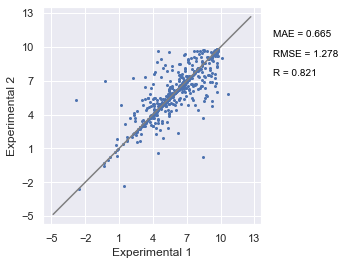

In [15]:
plot_diagram(df, ['Smiles_unify','Temperature'], 'value_nM_log')

# Further filtering

In [16]:
df_remove_bad_data = remove_bad_datapoints(df,['Smiles_unify','pH'],'value_nM_log',fold=np.log10(3))

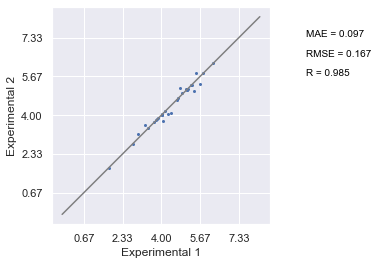

In [17]:
plot_diagram(df_remove_bad_data, ['Smiles_unify','pH'], 'value_nM_log')

In [18]:
df_remove_bad_data

,Smiles_unify,Smiles,value_nM,value_nM_log,ref,source,Temperature,pH,property
0,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,1.341523e+07,7.1276,CHEMBL1138134,ChEMBL,other,7.4,solubility
1,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,6.339401e+04,4.8020,CHEMBL1151763,ChEMBL,other,7.4,solubility
2,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,6.477938e+03,3.8114,CHEMBL1944507,ChEMBL,other,7.0,solubility
3,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CN4CCCC4)c...,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CN4CCCC4)c...,3.998760e+04,4.6019,CHEMBL1142456,ChEMBL,other,7.4,solubility
4,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CCO)ccc23)...,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CCO)ccc23)...,2.168691e+03,3.3362,CHEMBL1142456,ChEMBL,other,7.4,solubility
...,...,...,...,...,...,...,...,...,...
14813,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,4.656933e+05,5.6681,Wang et al. collected,Wangetal,NaN,NaN,solubility
14814,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,6.809261e+06,6.8331,Wang et al. collected,Wangetal,NaN,NaN,solubility
14815,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,3.302174e+07,7.5188,Wang et al. collected,Wangetal,NaN,NaN,solubility
14816,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,1.317650e+07,7.1198,Wang et al. collected,Wangetal,NaN,NaN,solubility


In [19]:
df_remove_bad_data['Temperature'].fillna('unknown', inplace=True)
df_remove_bad_data['pH'].fillna('unknown', inplace=True)

In [20]:
df_remove_bad_data['pH'].value_counts()

unknown    11851
7.4         1709
7.0          519
7.2           32
7.5           25
Name: pH, dtype: int64

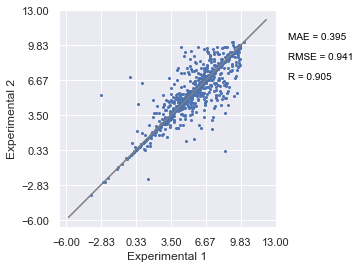

In [21]:
plot_diagram(df_remove_bad_data, ['Smiles_unify'], 'value_nM_log')

In [22]:
df_remove_bad_data = final_mean_value(df_remove_bad_data,['Smiles_unify'], 'value_nM_log')

In [23]:
df_dd = df_remove_bad_data.drop_duplicates(subset=['Smiles_unify'])
df_dd.shape

(11701, 10)

In [24]:
df_dd

,Smiles_unify,Smiles,value_nM,value_nM_log,ref,source,Temperature,pH,property,value_nM_log_mean
0,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCCNCC1,1.341523e+07,7.1276,CHEMBL1138134,ChEMBL,other,7.4,solubility,7.1276
1,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,CCc1ccc(S(=O)(=O)c2ccccc2)cc1S(=O)(=O)NCCCN(C)C,6.339401e+04,4.8020,CHEMBL1151763,ChEMBL,other,7.4,solubility,4.8020
2,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,O=C(Nc1cccc(-c2ccc(OC(F)(F)F)cc2)c1)N[C@@H]1CO...,6.477938e+03,3.8114,CHEMBL1944507,ChEMBL,other,7.0,solubility,3.8114
3,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CN4CCCC4)c...,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CN4CCCC4)c...,3.998760e+04,4.6019,CHEMBL1142456,ChEMBL,other,7.4,solubility,4.6019
4,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CCO)ccc23)...,Cn1ccnc1Sc1ccc(Nc2c(C#N)cnc3cc(/C=C/CCO)ccc23)...,2.168691e+03,3.3362,CHEMBL1142456,ChEMBL,other,7.4,solubility,3.3362
...,...,...,...,...,...,...,...,...,...,...
14813,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,4.656933e+05,5.6681,Wang et al. collected,Wangetal,unknown,unknown,solubility,5.6681
14814,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,6.809261e+06,6.8331,Wang et al. collected,Wangetal,unknown,unknown,solubility,6.8331
14815,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,3.302174e+07,7.5188,Wang et al. collected,Wangetal,unknown,unknown,solubility,7.5188
14816,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,1.317650e+07,7.1198,Wang et al. collected,Wangetal,unknown,unknown,solubility,7.1198


In [25]:
df_dd = df_dd[['Smiles_unify', 'value_nM_log_mean','property']]

In [26]:
df_dd.columns = ['Smiles_unify', 'value',  'property']

In [27]:
df = df_dd.copy()

# Compound Property analysis

In [28]:
mol_list = df['Smiles_unify'].map(Chem.MolFromSmiles)

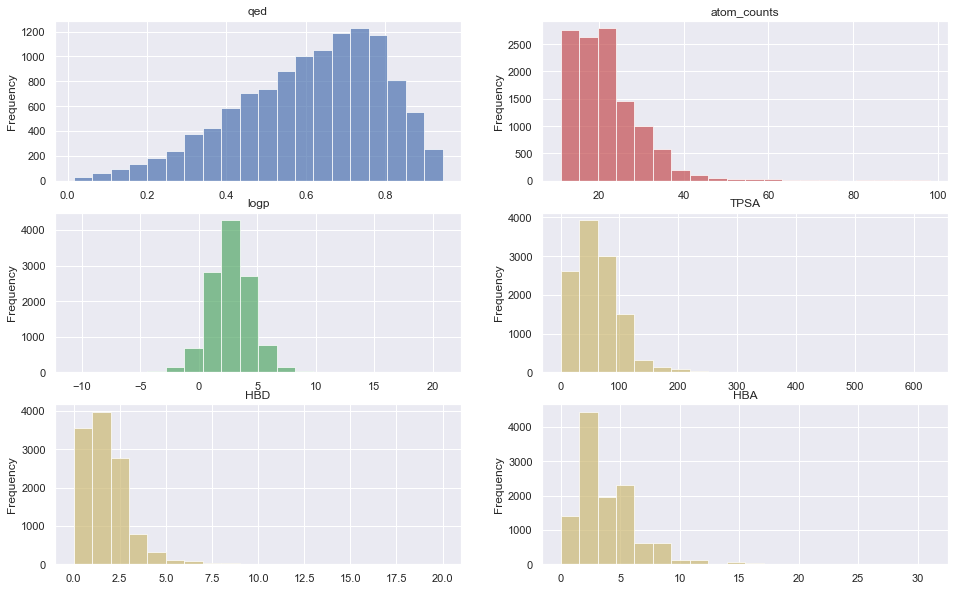

In [29]:
compound_property_analysis(mol_list)

# Data Split

In [30]:
df =  df.reset_index()


train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
df.loc[train_index,'scaffold_train_test_label'] = 'train'
df.loc[test_index,'scaffold_train_test_label'] = 'test'

train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
df.loc[train_index,'random_train_test_label'] = 'train'
df.loc[test_index,'random_train_test_label'] = 'test'

100%|██████████████████████████████████| 11701/11701 [00:00<00:00, 14079.51it/s]


In [31]:
df.to_csv('../data/final_datasets/water_sol_reg_final_data.csv',index=False)

In [32]:
df.shape

(11701, 6)